     |████████████████████████████████| 4.2MB 8.8MB/s 


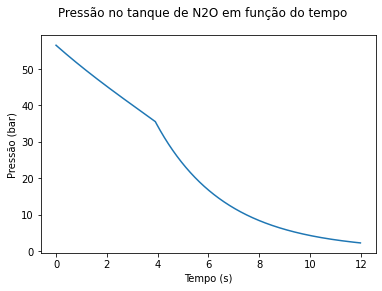

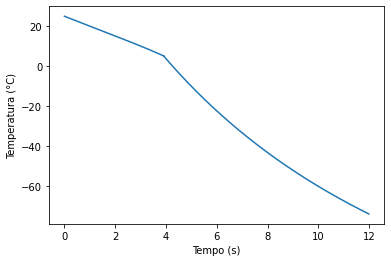

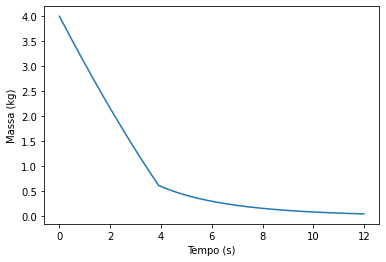

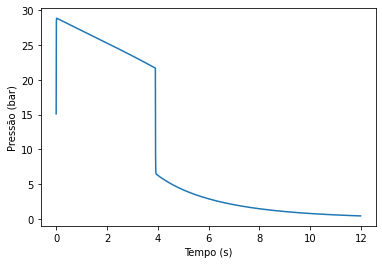

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


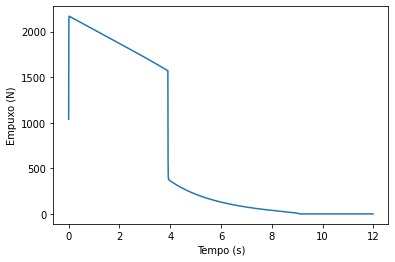

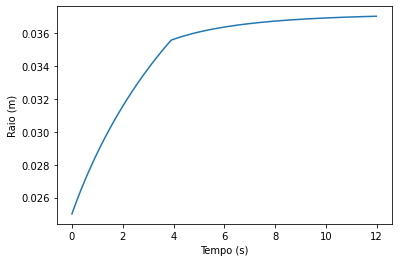

In [ ]:
!pip install CoolProp


def main ():
    
    import math
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from CoolProp.CoolProp import PropsSI
    from scipy.integrate import trapz

    '''Constantes'''
    
    p_atm = 101325.
    T_atm = 298.
    initial_mass = 4.
    mass = initial_mass
    tank_length = 600/1000
    tank_diameter = 115./1000.
    tank_volume = 0.25*math.pi*tank_length*tank_diameter**2
    injector_hole_diameter = 0.0054
    number_of_inj_holes = 1
    injector_area = number_of_inj_holes*0.25*math.pi*injector_hole_diameter**2
    vent_diameter = 0.5/1000
    vent_area = 0.25*math.pi*vent_diameter**2
    Cd = 0.66
    Cd_vent=0.6
    step = 0.002

    # Initial equilibrium state
    T = 298.15
    To = 3347 #Temperatura na câmara de combustão (K)
    P_cam = p_atm
    rho_liquid = PropsSI('D','T',T,'Q',0,'NitrousOxide')
    rho_vapor = PropsSI('D','T',T,'Q',1,'NitrousOxide')
    fluid_quality = (rho_vapor*rho_liquid*tank_volume - rho_vapor*initial_mass)/(initial_mass*(rho_liquid-rho_vapor))
    vapor_mass = fluid_quality*mass
    liquid_mass = (1.-fluid_quality)*mass
    p = PropsSI('P','T',T,'Q',fluid_quality,'NitrousOxide')
    s_liquid = PropsSI('S','T',T,'Q',0,'NitrousOxide')
    s_vapor = PropsSI('S','T',T,'Q',1,'NitrousOxide')
    s = s_liquid*(1.-fluid_quality) + s_vapor*fluid_quality
    h = PropsSI('H','T',T,'Q',fluid_quality,'NitrousOxide')
    rho = PropsSI('D','T',T,'Q',fluid_quality,'NitrousOxide')
    rho_downstream = PropsSI('D','S',s,'P',P_cam,'NitrousOxide')
    h_downstream = PropsSI('H','S',s,'P',P_cam,'NitrousOxide')
    vapor_pressure_out = PropsSI('P','S',s,'T|gas',To,'NitrousOxide')
    total_entropy = s*initial_mass

    Mm = 26.912 #Massa molar dos produtos da combustão (kg/kmol)
    Lgrain = 0.2 #Comprimento do grão de parafina (m)
    Vol = 2.2*10**-3 #Volume livre na câmara (m^3)
    pcomb = 900 #Densidade da parafina (kg/m^3)
    R = 8314/Mm #Constante universal dos gases dividida pela massa molar dos produtos de combustão
    Dthroat = 26./1000 #Diâmetro da garganta (m)
    n_cstar = 0.885 #Eficiência da combustão
    k = 1.1475 #Razão entre calores específicos dos produtos de combustão
    Dint = 0.050 #Diâmetro interno do grão de parafina (m)
    PGr = Dint/2 #Raio interno do grão de parafina (m)
    n_cf = 0.95 #Eficiência de Cf

    pressure_list = []
    temperature_list = []
    mass_list = []
    iteration = -1
    time = []
    chamber_pressure =[]
    thrust = []
    grain_radius = []

    while fluid_quality < 1 and liquid_mass>0.:
      iteration += 1
      mdot_inc = Cd*injector_area*math.sqrt(2.*rho_liquid*(p-P_cam))
      mdot_HEM = Cd*injector_area*rho_downstream*math.sqrt(2*(h-h_downstream))
      kappa = math.sqrt((p-P_cam)/(vapor_pressure_out-P_cam))
      mdot_inj = (mdot_inc + kappa*mdot_HEM)/(1+kappa)
      gamma = PropsSI('C','P',p,'Q',1,'NitrousOxide')/PropsSI('CVMASS','P',p,'Q',1,'NitrousOxide')
      mdot_vent = vent_area*Cd_vent*math.sqrt(gamma*p*rho_vapor*math.pow(2./(gamma+1.),(gamma+1.)/(gamma-1.)))
      outmass_liquid = mdot_inj*step
      outmass_vapor = mdot_vent*step
      vapor_mass = vapor_mass - outmass_vapor
      liquid_mass = liquid_mass - outmass_liquid
      mass = vapor_mass + liquid_mass
      total_entropy = total_entropy - outmass_liquid*s_liquid - outmass_vapor*s_vapor
      s = total_entropy/mass
      rho = mass/tank_volume
      T = PropsSI('T','S',s,'D',rho,'NitrousOxide')
      p = PropsSI('P','S',s,'D',rho,'NitrousOxide')
      h = PropsSI('H','S',s,'D',rho,'NitrousOxide')
      fluid_quality = PropsSI('Q','S',s,'D',rho,'NitrousOxide')
      rho_liquid = PropsSI('D','T',T,'Q',0,'NitrousOxide')
      rho_vapor = PropsSI('D','T',T,'Q',1,'NitrousOxide')
      s_liquid = PropsSI('S','T',T,'Q',0,'NitrousOxide')
      s_vapor = PropsSI('S','T',T,'Q',1,'NitrousOxide')
      rho_downstream = PropsSI('D','S',s,'P',P_cam,'NitrousOxide')
      h_downstream = PropsSI('H','S',s,'P',P_cam,'NitrousOxide')
      vapor_pressure_out = PropsSI('P','S',s,'T',To,'NitrousOxide')

      pgas = PropsSI('D','T',To,'P',P_cam,'NitrousOxide')
      dP_cam = (R*To/Vol)*(mdot_inj+Lgrain*2*np.pi*PGr*(pcomb-pgas)*1.28*10**(-5)*((mdot_inj/(np.pi*(PGr**2)))**0.94)-P_cam/n_cstar*(np.pi*(Dthroat**2)/4)*((k/(R*To))*(2/(k+1))**((k+1)/(k-1)))**0.5)
      dPGr = 1.28*10**(-5)*(mdot_inj/(np.pi*(PGr**2)))**0.94
      P_cam = P_cam + dP_cam*step
      PGr = PGr + dPGr*step
      cf = (((2*k**2)/(k-1))*(2/(k+1))**((k+1)/(k-1))*(1-(p_atm/P_cam)**((k-1)/k)))**0.5
      E = n_cf*cf*(np.pi*(Dthroat**2)/4)*P_cam

      pressure_list.append(p/10**5)
      temperature_list.append(T-273.15)
      mass_list.append(mass)
      chamber_pressure.append(P_cam/10**5)
      thrust.append(E)
      grain_radius.append(PGr)
      time.append(iteration*step)


    vapor_mass = vapor_mass + liquid_mass

    residual_mass = 0.05

    while mass > residual_mass:
      iteration += 1
      gamma = PropsSI('C','P',p,'Q',1,'NitrousOxide')/PropsSI('CVMASS','P',p,'Q',1,'NitrousOxide')
      mdot_inj = injector_area*Cd*math.sqrt(gamma*p*rho*math.pow(2./(gamma+1.),(gamma+1.)/(gamma-1.)))
      mdot_vent = vent_area*Cd_vent*math.sqrt(gamma*p*rho*math.pow(2./(gamma+1.),(gamma+1.)/(gamma-1.)))
      outmass_vapor = (mdot_inj + mdot_vent)*step
      vapor_mass = vapor_mass - outmass_vapor
      mass = vapor_mass
      total_entropy = total_entropy - outmass_vapor*s
      s = total_entropy/mass
      rho = mass/tank_volume
      if mass > 0.05:
        T = PropsSI('T','S',s,'D',rho,'NitrousOxide')
        p = PropsSI('P','S',s,'D',rho,'NitrousOxide')
        h = PropsSI('H','S',s,'D',rho,'NitrousOxide')

        pgas = PropsSI('D','T',To,'P',P_cam,'NitrousOxide')
        dP_cam = (R*To/Vol)*(mdot_inj+Lgrain*2*np.pi*PGr*(pcomb-pgas)*1.28*10**(-5)*((mdot_inj/(np.pi*(PGr**2)))**0.94)-P_cam/n_cstar*(np.pi*(Dthroat**2)/4)*((k/(R*To))*(2/(k+1))**((k+1)/(k-1)))**0.5)
        dPGr = 1.28*10**(-5)*(mdot_inj/(np.pi*(PGr**2)))**0.94
        P_cam = P_cam + dP_cam*step
        PGr = PGr + dPGr*step
        cf = (((2*k**2)/(k-1))*(2/(k+1))**((k+1)/(k-1))*(1-(p_atm/P_cam)**((k-1)/k)))**0.5
        E = n_cf*cf*(np.pi*(Dthroat**2)/4)*P_cam

        pressure_list.append(p/10**5)
        temperature_list.append(T-273.15)
        mass_list.append(mass)
        chamber_pressure.append(P_cam/10**5)
        thrust.append(E)
        grain_radius.append(PGr)
        time.append(iteration*step)
    
    fig = plt.figure()
    
    fig.suptitle('Pressão no tanque de N2O em função do tempo')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Pressão (bar)')
    plt.plot(time,pressure_list)
    plt.show()

    fig.suptitle('Temperatura no tanque de N2O em função do tempo')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Temperatura (°C)')
    plt.plot(time,temperature_list)
    plt.show()

    fig.suptitle('Massa no tanque de N2O em função do tempo')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Massa (kg)')
    plt.plot(time,mass_list)
    plt.show()

    fig.suptitle('Pressão na câmara')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Pressão (bar)')
    plt.plot(time,chamber_pressure)
    plt.show()

    fig.suptitle('Curva de empuxo')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Empuxo (N)')
    plt.plot(time,thrust)
    plt.show()

    fig.suptitle('Raio do grão')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Raio (m)')
    plt.plot(time,grain_radius)
    plt.show()


main ()